# XGBoost with SMOTE Tackle Probability Model
## Mis-classified Tackles

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
data = pd.read_csv('/Users/laurenmanis/Downloads/model_results.csv')
data.head()

,gamePlayId,gameId,playId,nflId,frameId,tackle_binary_single,prediction
0,2022090800.0529.0,2.022091e+09,529.0,38577.0,19.0,0,0.003838
1,2022090800.0529.0,2.022091e+09,529.0,38577.0,20.0,0,0.003388
2,2022090800.0529.0,2.022091e+09,529.0,38577.0,21.0,0,0.001570
3,2022090800.0529.0,2.022091e+09,529.0,38577.0,22.0,0,0.004507
4,2022090800.0529.0,2.022091e+09,529.0,38577.0,23.0,0,0.005843


Approximately 59,000 observations were misclassified as tackles in the model (were given tackle probabilities greater than 0.5 but were not actually tackles on the frame). What can we determine about these instances?

In [119]:
# Subset the model output data to only include instances of non-tackles with tackle predictions >50% 
tackles = data[data['tackle_binary_single'] == 0] 
tackles = tackles[tackles['prediction'] > 0.5]
tackles.head()

,gamePlayId,gameId,playId,nflId,frameId,tackle_binary_single,prediction
24,2022090800.0529.0,2.022091e+09,529.0,38577.0,43.0,0,0.523209
47,2022090800.0529.0,2.022091e+09,529.0,41239.0,34.0,0,0.515399
48,2022090800.0529.0,2.022091e+09,529.0,41239.0,35.0,0,0.555569
49,2022090800.0529.0,2.022091e+09,529.0,41239.0,36.0,0,0.557886
51,2022090800.0529.0,2.022091e+09,529.0,41239.0,38.0,0,0.604534


In [120]:
# Join back to tackles dataset
df = pd.read_csv('/Users/laurenmanis/Downloads/tackles.csv')
combined = df.merge(tackles[['gameId','playId','nflId','tackle_binary_single','prediction']], how='left', on=['gameId','playId','nflId']).dropna()
combined.sort_values(by='prediction', ascending=False)
combined.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,tackle_binary_single,prediction
4,2022090800,818,40107,1,0,0,0,0.0,0.732248
5,2022090800,818,40107,1,0,0,0,0.0,0.868178
6,2022090800,818,40107,1,0,0,0,0.0,0.851031
7,2022090800,818,40107,1,0,0,0,0.0,0.946847
8,2022090800,818,40107,1,0,0,0,0.0,0.937989


In [121]:
# Group by 'nflId', 'playId', and 'gameId' and find the index of the max prediction for each group
idx = combined.groupby(['nflId', 'playId', 'gameId'])['prediction'].idxmax()

# Use the index to get the rows with the maximum prediction for each group
max_prediction_per_player_play_game = combined.loc[idx]

# Determine the number of rows that fall into the following categories: actual tackles, assists, missed tackles   
tackles_act = max_prediction_per_player_play_game[max_prediction_per_player_play_game['tackle'] == 1].shape[0]
assists = max_prediction_per_player_play_game[max_prediction_per_player_play_game['assist'] == 1].shape[0]
missed = max_prediction_per_player_play_game[max_prediction_per_player_play_game['pff_missedTackle'] == 1].shape[0]
tot_rows = max_prediction_per_player_play_game.shape[0]

print('Actual tackle instances:', tackles_act)
print('Assisted tackles:',assists)
print('Missed tackles:', missed)


Actual tackle instances: 1349
Assisted tackles: 792
Missed tackles: 276


<Figure size 1000x600 with 0 Axes>

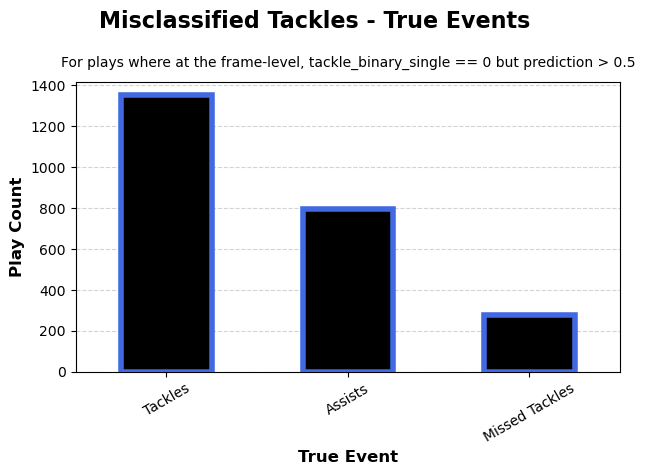

In [155]:
# Plot the above results 
res = {'Tackles':tackles_act,
       'Assists':assists,
       'Missed Tackles':missed}

res = pd.DataFrame([res]).transpose().reset_index().rename(columns={'index':'Event',0:'Count'}).set_index('Event')

plt.figure(figsize=(10, 6))
res.plot(kind='bar', color='black', edgecolor='royalblue', linewidth=4, zorder=3)
plt.grid(color='lightgrey', linestyle='--', axis='y', zorder=0) 
plt.title('For plays where at the frame-level, tackle_binary_single == 0 but prediction > 0.5', fontsize=10, y=1.025)  
plt.suptitle('Misclassified Tackles - True Events', fontsize=16, fontweight='bold')  
plt.xlabel('True Event', fontsize=12, fontweight='bold')
plt.ylabel('Play Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=30)  
plt.legend().remove()
plt.tight_layout()
plt.show()


In [122]:
# Convert the above to percentages 
print('Actual tackle instances:', tackles_act/tot_rows)
print('Assisted tackles:',assists/tot_rows)
print('Missed tackles:', missed/tot_rows)


Actual tackle instances: 0.559983395599834
Assisted tackles: 0.3287671232876712
Missed tackles: 0.11457036114570361


## Top Defenders by Predicted and Actual Tackles 

In [197]:
# Group the data and return one row per player per gamePlayId (final frame)
idx = data.groupby(['gamePlayId', 'nflId'])['frameId'].idxmax()
agg = data.loc[idx]

# Find the max prediction for each gamePlayId
max_pred = agg.groupby('gamePlayId')['prediction'].transform('max')

threshold = 0.00 * max_predictions

# Add a binary column indicating if the prediction is within 0.1% of the max prediction for that gamePlayId
agg['predicted_tackle'] = ((max_pred - agg['prediction']) <= threshold).astype(int)

# Calculate the number of actual and predicted tackles by nflId
tackles_df = agg.groupby('nflId').agg(
    actual_tackles=('tackle_binary_single', lambda x: (x==1).sum()),
    predicted_tackles=('predicted_tackle', lambda x: (x==1).sum())
).reset_index()

tackles_df = tackles_df.sort_values(by='predicted_tackles', ascending=False)

# Limit the dataset to only include the top 10 players by number of predicted tackles 
player_tackles = tackles_df.head(n=10)

# Join nflIds to player names 
players = pd.read_csv('/Users/laurenmanis/Downloads/players.csv')
player_tackles = player_tackles.merge(players[['nflId','displayName']], how='left', on='nflId')


,nflId,actual_tackles,predicted_tackles,displayName
0,46269.0,14,15,Foyesade Oluokun
1,44888.0,10,13,Alex Anzalone
2,41243.0,17,13,C.J. Mosley
3,53445.0,9,13,Zaven Collins
4,52436.0,10,13,Patrick Queen
5,54502.0,12,13,Jalen Pitre
6,54492.0,12,12,Devin Lloyd
7,46091.0,14,11,Rashaan Evans
8,47872.0,9,11,Bobby Okereke
9,47810.0,11,11,Johnathan Abram


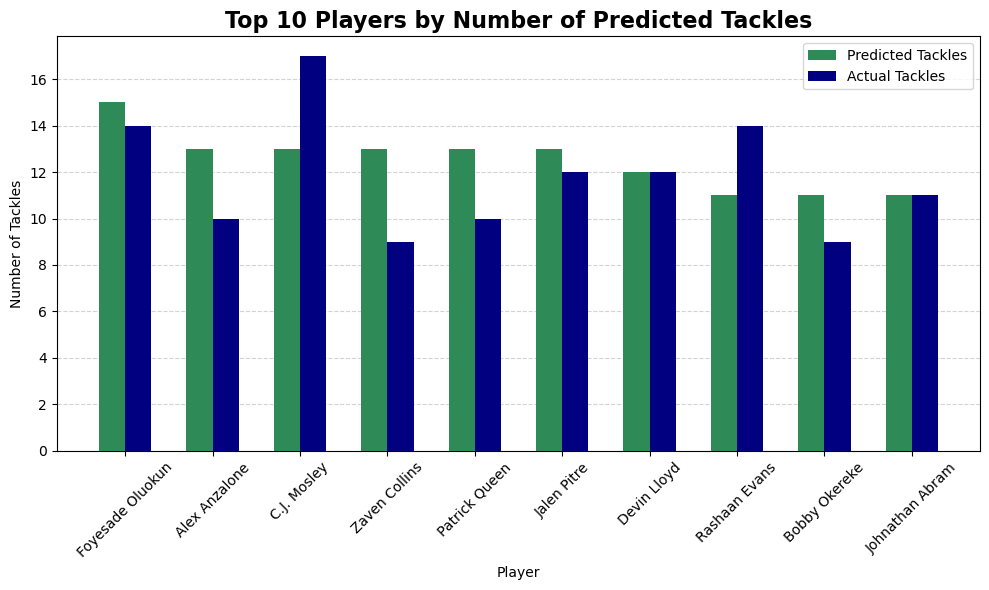

In [325]:
# Sort the DataFrame in descending order of predicted tackles
player_tackles = player_tackles.sort_values(by='predicted_tackles', ascending=False)

# Setting the positions and width for the bars
positions = np.arange(len(player_tackles))
width = 0.30 

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(positions - width/2, player_tackles['predicted_tackles'], width, label='Predicted Tackles', color='seagreen', zorder=3, linewidth=2)
plt.bar(positions + width/2, player_tackles['actual_tackles'], width, label='Actual Tackles', color='navy', zorder=3, linewidth=2)
plt.xlabel('Player')
plt.ylabel('Number of Tackles')
plt.title('Top 10 Players by Number of Predicted Tackles', fontsize=16, fontweight='bold')
plt.xticks(positions, player_tackles['displayName'], rotation=45) 
plt.grid(color='lightgrey', linestyle='--', axis='y', zorder=0)
plt.legend() 
plt.tight_layout()
plt.show()


## Confusion Matrix as Percentages 

In [318]:
# Compute classifcation outcomes as percentages 
tot_rows = data.shape[0]
true1_pred1 = data[(data['prediction'] > 0.5) & (data['tackle_binary_single'] == 1)].shape[0]
true1_pred0 = data[(data['prediction'] < 0.5) & (data['tackle_binary_single'] == 1)].shape[0]
true0_pred1 = data[(data['prediction'] > 0.5) & (data['tackle_binary_single'] == 0)].shape[0]
true0_pred0 = data[(data['prediction'] < 0.5) & (data['tackle_binary_single'] == 0)].shape[0]

true1 = data[data['tackle_binary_single'] == 1].shape[0]
true0 = data[data['tackle_binary_single'] == 0].shape[0]

print('Percent of true tackles predicted as tackles:',true1_pred1/true1)
print('Percent of true tackles predicted as non-tackles:',true1_pred0/true1)
print('Percent of non-tackles predicted as non-tackles:',true0_pred0/true0)
print('Percent of non-tackles predicted as non-tackles:',true0_pred1/true0)



Percent of true tackles predicted as tackles: 0.9703341767734055
Percent of true tackles predicted as non-tackles: 0.02966582322659454
Percent of non-tackles predicted as non-tackles: 0.8913344092726406
Percent of non-tackles predicted as non-tackles: 0.10866559072735943


In [319]:
# Convert values to percentages (to the nearest 1%)
true1_pred1 = round((true1_pred1/true1)*100, 2)
true1_pred0 = round((true1_pred1/true1)*100, 2)
true0_pred0 = round((true0_pred0/true0)*100, 2)
true0_pred1 = round((true0_pred1/true0)*100, 2)


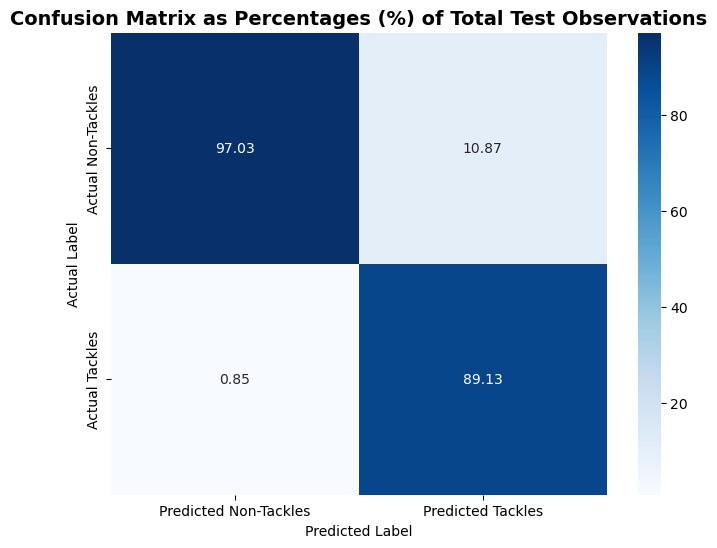

In [323]:
# Constructing the confusion matrix
confusion_matrix = [
    [true1_pred1, true0_pred1],  
    [true1_pred0, true0_pred0]   
]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Predicted Non-Tackles','Predicted Tackles'], yticklabels=['Actual Non-Tackles','Actual Tackles'])
plt.title('Confusion Matrix as Percentages (%) of Total Test Observations', fontweight='bold', fontsize=14)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()